In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd

In [3]:
X=[]
Y=[]
lines=[]

data_path='/content/drive/My Drive/Self-driving-car-dataset/'

images_path='/content/drive/My Drive/Self-driving-car-dataset/images/'

with open(data_path+'data.txt') as file:
    lines=file.readlines()


for line in lines:
    w=line.split()
    X.append(w[0])
    Y.append(float(w[1]))
        

In [9]:
#Do this 3-5 times, it will work in the end
import os
print(len(os.listdir(images_path)))

45573


In [10]:
cnt=0
for i,x in enumerate(X):
    X[i]=images_path+X[i]
    if os.path.isfile(X[i]):
        cnt+=1
    else:
        print(x[i])
    
print(cnt)

45406


In [11]:
import math

for i,y in enumerate(Y):
    Y[i]=(y*math.pi)/180
    
print(Y[89])

0.024609142453120045


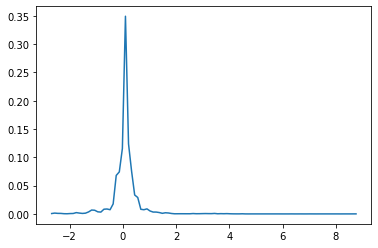

In [12]:
import matplotlib.pyplot as plt

counts,bin_edges=np.histogram(Y,bins=100,density=True)
pdf=counts/sum(counts)
plt.plot(bin_edges[1:],pdf)
plt.show()

In [13]:
import keras
import cv2

class Generator(keras.utils.Sequence):
    
    def __init__(self,X,Y,batch_size):
        self.X=X
        self.Y=Y
        self.batch_size=batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.X)/batch_size))
    
    def __getitem__(self,idx):
        #print(idx)
        batch_x=self.X[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_y=self.Y[idx*self.batch_size : (idx+1)*self.batch_size]
        
        x_vec=[]
        for img in batch_x:
            x_vec.append(cv2.resize(cv2.imread(img)[-150:],(200,66))/255.0)
            
        return np.array(x_vec),np.array(batch_y)

In [16]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D

width=200
height=66
channels=3
batch_size=100
epochs=30
model=Sequential()

import tensorflow.compat.v1 as tf

def conv2d(filters,kernel_size,strides,f=0):
  #For 1st layer to add input shape
  if f==1:
    return Conv2D(filters,kernel_size=kernel_size,strides=strides,input_shape=(width,height,channels),
                data_format='channels_last',activation='relu',
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))

  #For rest of the layers
  else:
    return Conv2D(filters,kernel_size=kernel_size,strides=strides,activation='relu',
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))
      

def dense(units):
  return Dense(units, activation='relu',
              kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
              use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))


def modifiedTanh(x):
   return tf.multiply(tf.atan(x), 2) 

tf.keras.utils.get_custom_objects().update({'modifiedTanh': modifiedTanh})


#Conv Layer-1
model.add(conv2d(24,5,2,1))
# model.add(BatchNormalization())

#Conv Layer-2
model.add(conv2d(36,5,2))
# model.add(BatchNormalization())

#Conv Layer-3
model.add(conv2d(48,5,2))
# model.add(BatchNormalization())

#Conv Layer-4
model.add(conv2d(64,3,1))
# model.add(BatchNormalization())

#Conv Layer-5
model.add(conv2d(64,3,1))
# model.add(BatchNormalization())

#Flattening
model.add(Flatten())

#Fully Connected Layer-1
model.add(dense(1164))
model.add(Dropout(0.2))

#Fully Connected Layer-2
model.add(dense(100))
model.add(Dropout(0.2))

#Fully Connected Layer-3
model.add(dense(50))
model.add(Dropout(0.2))

#Fully Connected Layer-4
model.add(dense(10))
model.add(Dropout(0.2))

# The Output Layer :
model.add(Dense(1))



In [17]:
# Compile the network :


def loss(yTrue,yPred):
  L2NormConst = 0.001
  train_vars = model.trainable_variables

  loss=tf.reduce_mean(tf.square(tf.subtract(yTrue, yPred)));
  if len(train_vars)!=0:
    loss+=tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst

  return loss

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=loss, optimizer=optimizer, metrics=[loss,'mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 31, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 14, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 5, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 3, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 1, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1164)             

In [19]:
# split=int(.8*len(X))
# X_train=X[0:split]
# X_val=X[split:]
# Y_train=Y[0:split]
# Y_val=Y[split:]
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X, Y, test_size=0.25, random_state=10)

print("train:",len(X_train),len(Y_train))
print("val:",len(X_val),len(Y_val))

train: 34054 34054
val: 11352 11352


In [20]:
from sklearn.metrics import mean_squared_error

z=[0]*len(Y_val)

mean_squared_error(Y_val, z)

0.2898044832855096

In [29]:
batch_size=128
training_batch_generator =Generator(X_train, Y_train, batch_size)
validation_batch_generator =Generator(X_val, Y_val, batch_size)

model.fit(training_batch_generator,
            steps_per_epoch=int(len(X_train)//batch_size),
            epochs = epochs,
            verbose=1,
            workers=8,
            validation_data=validation_batch_generator,
            validation_steps=int(len(X_val)//batch_size))

Epoch 1/30
266/266 [==============================] - 3402s 13s/step - loss: 5.6983 - mean_squared_error: 0.3513 - val_loss: 5.1360 - val_mean_squared_error: 0.2907
Epoch 2/30
266/266 [==============================] - 136s 512ms/step - loss: 4.7535 - mean_squared_error: 0.3036 - val_loss: 4.3936 - val_mean_squared_error: 0.2906
Epoch 3/30
266/266 [==============================] - 135s 508ms/step - loss: 4.1212 - mean_squared_error: 0.2978 - val_loss: 3.8669 - val_mean_squared_error: 0.2904
Epoch 4/30
266/266 [==============================] - 135s 507ms/step - loss: 3.6692 - mean_squared_error: 0.2944 - val_loss: 3.4861 - val_mean_squared_error: 0.2899
Epoch 5/30
266/266 [==============================] - 136s 512ms/step - loss: 3.3398 - mean_squared_error: 0.2911 - val_loss: 3.2000 - val_mean_squared_error: 0.2817
Epoch 6/30
266/266 [==============================] - 136s 511ms/step - loss: 3.0936 - mean_squared_error: 0.2842 - val_loss: 2.9823 - val_mean_squared_error: 0.2700
Epoch

In [31]:
model.save('model.h5')
# from keras.models import load_model 
# model = load_model("m1.h5") 